In [214]:
%reset -f
#pip install tmdbsimple
import pandas as pd
import numpy as np
from numpy.random import shuffle
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
import tmdbsimple as tmdb
import seaborn as sns
import json
sns.set()
tmdb.API_KEY = 'abcd9827ce3fb2298891370ff0cd0e58'

In [215]:
def takeInfos(id):
    atores = []
    crews = []
    keywords = []

    movie = tmdb.Movies(id)

    response = movie.info()
    popularity = round(movie.popularity)
    media = round(movie.vote_average)
    title = movie.title
    for ator in movie.credits()['cast']: atores.append(ator['name'])
    for crew in movie.credits()['crew']: crews.append(crew['name'])
    for keyword in movie.keywords()['keywords']: keywords.append(keyword['name'])
    for similar in movie.similar_movies()['results']: 
        sTitles.append(similar['title'])
        sPopularity.append(round(similar["popularity"]))
        sMedia.append(round(similar["vote_average"]))
    
    return title,popularity,media,atores,crews,keywords

def takeOffInfos(line):
    atores = []
    crews = []
    keywords = []

    popularity = round(movies.iloc[line].popularity)
    media = round(movies.iloc[line].vote_average)
    title = movies.iloc[line].title
    
    i = 0
    x = credits.iloc[0].cast[i:].find('"name": ')
    y = credits.iloc[0].cast[x:].find(",")+x
    name=[credits.iloc[0].cast[x+9:y-1]]
    for i in range(2):
        i = y+16
        x = credits.iloc[0].cast[i:].find('"name": ')
        y = credits.iloc[0].cast[i+x:].find('",')+x+i
        name.append(credits.iloc[0].cast[i+x+9:y])
    atores = name
    
    x = credits.iloc[0].crew.find('"name": ')
    y = credits.iloc[0].crew[x:].find(",")+x
    crew =[credits.iloc[0].crew[x+9:y-2]]
    
    x = movies.iloc[0].keywords.find('"name": ')
    y = movies.iloc[0].keywords[x:].find(",")+x
    name=[movies.iloc[0].keywords[x+9:y-1]]
    for i in range(2):
        i = y+4
        x = movies.iloc[0].keywords[i:].find('"name": ')
        y = movies.iloc[0].keywords[i+x:].find('"},')+x+i
        name.append(movies.iloc[0].keywords[i+x+9:y])
    keywords = name
    
    return title,popularity,media,atores,crews,keywords

def NormalizeCat(X): #Não esta sendo usado
    global perda
    i = 0
    n = len(X)
    limit = 300
    if len(X)>limit:perda+=1
    while(len(X)<limit):
        if i == n: i = 0
        X.append(X[i])
        i+=1
    while(len(X)>limit):
        X.pop()
    return X
        

In [216]:
#Função para Interface de Usuario
def UI():
    Entrada = str(input("Qual filme você deseja saber a nota?"))
    search = tmdb.Search()
    response = search.movie(query=Entrada)
    if len(Search.results) == 0: print("Desculpe não encontrei nenhum filme com este nome...")
    if len(Search.resuslts) > 1:
        print("Encontrei os seguintes filmes com este nome, qual deles você deseja?")
        for i in range(len(search.results)): print(str(search.results[i]['title']) + "  [i]")
        Escolido = int(input())
    else: Escolido = 0
    X,y = Codex.Feed(search.results[Escolido]['id'])
    saida = Naive.predict([X])
    print("A nota desse filme provavelmente será {0}".format(saida[0]))
    print("For DEVS: a nota real é {0}".format(search.results[Escolido]['vote_average']))
    

In [217]:
class Encoder:
    def __init__(self,lista):
        self.Codex = []
        self.atualIndex = 1
        self.fit(lista)
        
    def fit(self,lista):
        for item in lista:
            onList = False
            for code in self.Codex:
                if item == code[0]: onList = True
            if not onList:
                self.Codex.append([item,self.atualIndex])
                self.atualIndex+=1
    
    def transform(self,lista):
        resposta = []
        for item in lista:
            for code in self.Codex:
                if item == code[0]: resposta.append(code[1])
        return resposta
    
    def fit_transform(self,lista):
        self.fit(lista)
        return self.transform(lista)
    
    def inverse_transform(self,lista):
        resposta = []
        for item in lista:
            for code in self.Codex:
                if item == code[1]: resposta.append(code[0])
        return resposta
    
    def show(self):
        print(self.Codex)
    
    def Feed(self,line):
        title,popularity,media,atores,crews,keywords = takeOffInfos(line)
        self.fit([title])
        self.fit(atores)
        self.fit(crews)
        self.fit(keywords)

        Atores = self.transform(atores)
        Crews = self.transform(crews)
        Keywords = self.transform(keywords)
        X = self.fit_transform(["P"+str(popularity/10)])
        if len(Crews)>0:X.append(Crews[0])
        else: X.append(X[-1])
        for i in range(3):
            if len(Atores)>(i): X.append(Atores[i])
            else: X.append(X[-1])

            if len(Keywords)>(i): X.append(Keywords[i])
            else: X.append(X[-1])
        y = round(media/2)
        return X,y

In [218]:
credits = pd.read_csv("tmdb_5000_credits.csv")
movies = pd.read_csv("tmdb_5000_movies.csv")

In [219]:
#Definição de banco de treino e teste
IDlist = list(movies["id"])
n = 4000
IDTrainList = IDlist[:n]
IDTestList = IDlist[n:]

In [220]:
Codex = Encoder(['M0',"M1","M2",'M3','M4','M5','M6','M7','M8','M9','M10'])
Naive = MultinomialNB()
VectorMachine = svm.SVC()

In [221]:
#Treino para SVM e Naive Bayes
n = 4000
i = 0
X = []
y = []
shuffle(IDTrainList)
for i in range(len(IDTrainList)):
    try:
        X.append(Codex.Feed(i)[0])
        y.append(Codex.Feed(i)[1])
        i += 1
        print(str(i)+"/"+str(n)+" [{0}]".format(y[i-1]))
        if i == n:break
    except:
        text = input("Press Enter")
        if text == "end":break
print("\nEnsinando...")
Naive.fit(X,y)
VectorMachine.fit(X, y)

1/4000 [4.0]
2/4000 [4.0]
3/4000 [3.0]
4/4000 [4.0]
5/4000 [3.0]
6/4000 [3.0]
7/4000 [4.0]
8/4000 [4.0]
9/4000 [4.0]
10/4000 [3.0]
11/4000 [2.0]
12/4000 [3.0]
13/4000 [4.0]
14/4000 [3.0]
15/4000 [3.0]
16/4000 [3.0]
17/4000 [4.0]
18/4000 [3.0]
19/4000 [3.0]
20/4000 [4.0]
21/4000 [3.0]
22/4000 [3.0]
23/4000 [4.0]
24/4000 [3.0]
25/4000 [4.0]
26/4000 [4.0]
27/4000 [4.0]
28/4000 [3.0]
29/4000 [3.0]
30/4000 [4.0]
31/4000 [4.0]
32/4000 [4.0]
33/4000 [3.0]
34/4000 [3.0]
35/4000 [4.0]
36/4000 [3.0]
37/4000 [3.0]
38/4000 [3.0]
39/4000 [3.0]
40/4000 [3.0]
41/4000 [3.0]
42/4000 [2.0]
43/4000 [4.0]
44/4000 [3.0]
45/4000 [4.0]
46/4000 [4.0]
47/4000 [4.0]
48/4000 [4.0]
49/4000 [3.0]
50/4000 [4.0]
51/4000 [3.0]
52/4000 [4.0]
53/4000 [3.0]
54/4000 [3.0]
55/4000 [4.0]
56/4000 [4.0]
57/4000 [4.0]
58/4000 [4.0]
59/4000 [3.0]
60/4000 [3.0]
61/4000 [4.0]
62/4000 [2.0]
63/4000 [3.0]
64/4000 [4.0]
65/4000 [3.0]
66/4000 [4.0]
67/4000 [4.0]
68/4000 [3.0]
69/4000 [4.0]
70/4000 [4.0]
71/4000 [2.0]
72/4000 [2.0]
7

555/4000 [3.0]
556/4000 [2.0]
557/4000 [4.0]
558/4000 [4.0]
559/4000 [4.0]
560/4000 [4.0]
561/4000 [2.0]
562/4000 [4.0]
563/4000 [3.0]
564/4000 [2.0]
565/4000 [3.0]
566/4000 [4.0]
567/4000 [4.0]
568/4000 [3.0]
569/4000 [3.0]
570/4000 [3.0]
571/4000 [3.0]
572/4000 [4.0]
573/4000 [4.0]
574/4000 [4.0]
575/4000 [3.0]
576/4000 [3.0]
577/4000 [2.0]
578/4000 [3.0]
579/4000 [2.0]
580/4000 [4.0]
581/4000 [3.0]
582/4000 [3.0]
583/4000 [3.0]
584/4000 [4.0]
585/4000 [3.0]
586/4000 [4.0]
587/4000 [3.0]
588/4000 [4.0]
589/4000 [3.0]
590/4000 [3.0]
591/4000 [3.0]
592/4000 [4.0]
593/4000 [4.0]
594/4000 [2.0]
595/4000 [2.0]
596/4000 [2.0]
597/4000 [2.0]
598/4000 [3.0]
599/4000 [3.0]
600/4000 [3.0]
601/4000 [3.0]
602/4000 [2.0]
603/4000 [2.0]
604/4000 [3.0]
605/4000 [3.0]
606/4000 [3.0]
607/4000 [2.0]
608/4000 [3.0]
609/4000 [2.0]
610/4000 [4.0]
611/4000 [2.0]
612/4000 [3.0]
613/4000 [3.0]
614/4000 [4.0]
615/4000 [4.0]
616/4000 [2.0]
617/4000 [3.0]
618/4000 [4.0]
619/4000 [3.0]
620/4000 [2.0]
621/4000 [

1107/4000 [3.0]
1108/4000 [3.0]
1109/4000 [4.0]
1110/4000 [3.0]
1111/4000 [3.0]
1112/4000 [3.0]
1113/4000 [4.0]
1114/4000 [3.0]
1115/4000 [4.0]
1116/4000 [2.0]
1117/4000 [4.0]
1118/4000 [4.0]
1119/4000 [3.0]
1120/4000 [4.0]
1121/4000 [4.0]
1122/4000 [3.0]
1123/4000 [3.0]
1124/4000 [2.0]
1125/4000 [3.0]
1126/4000 [4.0]
1127/4000 [3.0]
1128/4000 [3.0]
1129/4000 [3.0]
1130/4000 [3.0]
1131/4000 [2.0]
1132/4000 [3.0]
1133/4000 [3.0]
1134/4000 [3.0]
1135/4000 [2.0]
1136/4000 [4.0]
1137/4000 [4.0]
1138/4000 [2.0]
1139/4000 [3.0]
1140/4000 [3.0]
1141/4000 [4.0]
1142/4000 [4.0]
1143/4000 [2.0]
1144/4000 [4.0]
1145/4000 [2.0]
1146/4000 [4.0]
1147/4000 [3.0]
1148/4000 [3.0]
1149/4000 [4.0]
1150/4000 [4.0]
1151/4000 [4.0]
1152/4000 [3.0]
1153/4000 [4.0]
1154/4000 [3.0]
1155/4000 [2.0]
1156/4000 [2.0]
1157/4000 [4.0]
1158/4000 [3.0]
1159/4000 [4.0]
1160/4000 [4.0]
1161/4000 [4.0]
1162/4000 [4.0]
1163/4000 [3.0]
1164/4000 [2.0]
1165/4000 [3.0]
1166/4000 [4.0]
1167/4000 [3.0]
1168/4000 [4.0]
1169/400

1627/4000 [2.0]
1628/4000 [3.0]
1629/4000 [3.0]
1630/4000 [2.0]
1631/4000 [3.0]
1632/4000 [2.0]
1633/4000 [4.0]
1634/4000 [2.0]
1635/4000 [3.0]
1636/4000 [3.0]
1637/4000 [2.0]
1638/4000 [2.0]
1639/4000 [4.0]
1640/4000 [3.0]
1641/4000 [4.0]
1642/4000 [3.0]
1643/4000 [3.0]
1644/4000 [2.0]
1645/4000 [3.0]
1646/4000 [2.0]
1647/4000 [2.0]
1648/4000 [4.0]
1649/4000 [3.0]
1650/4000 [3.0]
1651/4000 [2.0]
1652/4000 [2.0]
1653/4000 [2.0]
1654/4000 [3.0]
1655/4000 [2.0]
1656/4000 [3.0]
1657/4000 [2.0]
1658/4000 [4.0]
1659/4000 [3.0]
1660/4000 [4.0]
1661/4000 [3.0]
1662/4000 [3.0]
1663/4000 [4.0]
1664/4000 [4.0]
1665/4000 [3.0]
1666/4000 [4.0]
1667/4000 [3.0]
1668/4000 [2.0]
1669/4000 [3.0]
1670/4000 [2.0]
1671/4000 [2.0]
1672/4000 [4.0]
1673/4000 [2.0]
1674/4000 [3.0]
1675/4000 [2.0]
1676/4000 [3.0]
1677/4000 [3.0]
1678/4000 [4.0]
1679/4000 [2.0]
1680/4000 [3.0]
1681/4000 [3.0]
1682/4000 [4.0]
1683/4000 [3.0]
1684/4000 [4.0]
1685/4000 [4.0]
1686/4000 [3.0]
1687/4000 [3.0]
1688/4000 [4.0]
1689/400

2140/4000 [2.0]
2141/4000 [3.0]
2142/4000 [4.0]
2143/4000 [3.0]
2144/4000 [2.0]
2145/4000 [3.0]
2146/4000 [3.0]
2147/4000 [2.0]
2148/4000 [3.0]
2149/4000 [4.0]
2150/4000 [2.0]
2151/4000 [3.0]
2152/4000 [4.0]
2153/4000 [4.0]
2154/4000 [3.0]
2155/4000 [3.0]
2156/4000 [4.0]
2157/4000 [3.0]
2158/4000 [3.0]
2159/4000 [3.0]
2160/4000 [3.0]
2161/4000 [2.0]
2162/4000 [3.0]
2163/4000 [2.0]
2164/4000 [2.0]
2165/4000 [3.0]
2166/4000 [2.0]
2167/4000 [4.0]
2168/4000 [4.0]
2169/4000 [3.0]
2170/4000 [3.0]
2171/4000 [4.0]
2172/4000 [2.0]
2173/4000 [4.0]
2174/4000 [3.0]
2175/4000 [2.0]
2176/4000 [4.0]
2177/4000 [3.0]
2178/4000 [4.0]
2179/4000 [4.0]
2180/4000 [3.0]
2181/4000 [2.0]
2182/4000 [4.0]
2183/4000 [3.0]
2184/4000 [3.0]
2185/4000 [4.0]
2186/4000 [2.0]
2187/4000 [4.0]
2188/4000 [4.0]
2189/4000 [3.0]
2190/4000 [2.0]
2191/4000 [2.0]
2192/4000 [4.0]
2193/4000 [3.0]
2194/4000 [3.0]
2195/4000 [2.0]
2196/4000 [3.0]
2197/4000 [3.0]
2198/4000 [3.0]
2199/4000 [3.0]
2200/4000 [2.0]
2201/4000 [3.0]
2202/400

2659/4000 [2.0]
2660/4000 [4.0]
2661/4000 [3.0]
2662/4000 [4.0]
2663/4000 [4.0]
2664/4000 [3.0]
2665/4000 [4.0]
2666/4000 [4.0]
2667/4000 [4.0]
2668/4000 [4.0]
2669/4000 [4.0]
2670/4000 [3.0]
2671/4000 [2.0]
2672/4000 [4.0]
2673/4000 [4.0]
2674/4000 [2.0]
2675/4000 [3.0]
2676/4000 [4.0]
2677/4000 [3.0]
2678/4000 [3.0]
2679/4000 [3.0]
2680/4000 [2.0]
2681/4000 [3.0]
2682/4000 [3.0]
2683/4000 [4.0]
2684/4000 [3.0]
2685/4000 [2.0]
2686/4000 [2.0]
2687/4000 [2.0]
2688/4000 [2.0]
2689/4000 [3.0]
2690/4000 [3.0]
2691/4000 [3.0]
2692/4000 [3.0]
2693/4000 [3.0]
2694/4000 [3.0]
2695/4000 [4.0]
2696/4000 [2.0]
2697/4000 [2.0]
2698/4000 [3.0]
2699/4000 [2.0]
2700/4000 [3.0]
2701/4000 [4.0]
2702/4000 [4.0]
2703/4000 [3.0]
2704/4000 [3.0]
2705/4000 [3.0]
2706/4000 [2.0]
2707/4000 [2.0]
2708/4000 [3.0]
2709/4000 [3.0]
2710/4000 [3.0]
2711/4000 [3.0]
2712/4000 [4.0]
2713/4000 [4.0]
2714/4000 [3.0]
2715/4000 [3.0]
2716/4000 [2.0]
2717/4000 [4.0]
2718/4000 [4.0]
2719/4000 [4.0]
2720/4000 [4.0]
2721/400

3178/4000 [4.0]
3179/4000 [4.0]
3180/4000 [3.0]
3181/4000 [3.0]
3182/4000 [3.0]
3183/4000 [3.0]
3184/4000 [4.0]
3185/4000 [3.0]
3186/4000 [3.0]
3187/4000 [3.0]
3188/4000 [3.0]
3189/4000 [4.0]
3190/4000 [4.0]
3191/4000 [4.0]
3192/4000 [2.0]
3193/4000 [3.0]
3194/4000 [3.0]
3195/4000 [4.0]
3196/4000 [2.0]
3197/4000 [3.0]
3198/4000 [4.0]
3199/4000 [2.0]
3200/4000 [4.0]
3201/4000 [3.0]
3202/4000 [3.0]
3203/4000 [3.0]
3204/4000 [2.0]
3205/4000 [3.0]
3206/4000 [4.0]
3207/4000 [4.0]
3208/4000 [3.0]
3209/4000 [4.0]
3210/4000 [3.0]
3211/4000 [4.0]
3212/4000 [4.0]
3213/4000 [4.0]
3214/4000 [3.0]
3215/4000 [3.0]
3216/4000 [3.0]
3217/4000 [4.0]
3218/4000 [4.0]
3219/4000 [4.0]
3220/4000 [2.0]
3221/4000 [3.0]
3222/4000 [4.0]
3223/4000 [4.0]
3224/4000 [4.0]
3225/4000 [4.0]
3226/4000 [4.0]
3227/4000 [4.0]
3228/4000 [4.0]
3229/4000 [4.0]
3230/4000 [4.0]
3231/4000 [4.0]
3232/4000 [2.0]
3233/4000 [4.0]
3234/4000 [4.0]
3235/4000 [4.0]
3236/4000 [2.0]
3237/4000 [4.0]
3238/4000 [3.0]
3239/4000 [4.0]
3240/400

3691/4000 [4.0]
3692/4000 [3.0]
3693/4000 [3.0]
3694/4000 [3.0]
3695/4000 [3.0]
3696/4000 [3.0]
3697/4000 [4.0]
3698/4000 [4.0]
3699/4000 [4.0]
3700/4000 [4.0]
3701/4000 [4.0]
3702/4000 [4.0]
3703/4000 [3.0]
3704/4000 [4.0]
3705/4000 [4.0]
3706/4000 [3.0]
3707/4000 [4.0]
3708/4000 [3.0]
3709/4000 [4.0]
3710/4000 [4.0]
3711/4000 [3.0]
3712/4000 [4.0]
3713/4000 [3.0]
3714/4000 [3.0]
3715/4000 [4.0]
3716/4000 [4.0]
3717/4000 [4.0]
3718/4000 [2.0]
3719/4000 [2.0]
3720/4000 [4.0]
3721/4000 [4.0]
3722/4000 [4.0]
3723/4000 [4.0]
3724/4000 [4.0]
3725/4000 [3.0]
3726/4000 [3.0]
3727/4000 [4.0]
3728/4000 [3.0]
3729/4000 [4.0]
3730/4000 [4.0]
3731/4000 [3.0]
3732/4000 [3.0]
3733/4000 [4.0]
3734/4000 [3.0]
3735/4000 [4.0]
3736/4000 [3.0]
3737/4000 [2.0]
3738/4000 [4.0]
3739/4000 [4.0]
3740/4000 [4.0]
3741/4000 [4.0]
3742/4000 [3.0]
3743/4000 [2.0]
3744/4000 [4.0]
3745/4000 [2.0]
3746/4000 [4.0]
3747/4000 [2.0]
3748/4000 [3.0]
3749/4000 [3.0]
3750/4000 [4.0]
3751/4000 [4.0]
3752/4000 [3.0]
3753/400

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [241]:
#Bloco de para teste, Matriz Naive e Matriz2 SVM
i = 0
n = 803
shuffle(IDTestList)
Matriz = np.array([[0,0,0,0,0],
         [0,0,0,0,0],
         [0,0,0,0,0],
          [0,0,0,0,0],
          [0,0,0,0,0]])
Matriz2 = Matriz
for i in range(len(IDTestList)): 
    X,y = Codex.Feed(i)
    #saida = Naive.predict([X])
    saida2 = VectorMachine.predict([X])
    
    #Matriz[int(saida[0])][int(y)]+=1
    Matriz2[int(saida2[0])][int(y)]+=1

    i += 1
    print(str(i)+"/"+str(n)+" [{0} , {1}]".format(saida[0],y))
    if i == n:break

1/803 [4.0 , 4.0]
2/803 [4.0 , 4.0]
3/803 [4.0 , 3.0]
4/803 [4.0 , 4.0]
5/803 [4.0 , 3.0]
6/803 [4.0 , 3.0]
7/803 [4.0 , 4.0]
8/803 [4.0 , 4.0]
9/803 [4.0 , 4.0]
10/803 [4.0 , 3.0]
11/803 [4.0 , 2.0]
12/803 [4.0 , 3.0]
13/803 [4.0 , 4.0]
14/803 [4.0 , 3.0]
15/803 [4.0 , 3.0]
16/803 [4.0 , 3.0]
17/803 [4.0 , 4.0]
18/803 [4.0 , 3.0]
19/803 [4.0 , 3.0]
20/803 [4.0 , 4.0]
21/803 [4.0 , 3.0]
22/803 [4.0 , 3.0]
23/803 [4.0 , 4.0]
24/803 [4.0 , 3.0]
25/803 [4.0 , 4.0]
26/803 [4.0 , 4.0]
27/803 [4.0 , 4.0]
28/803 [4.0 , 3.0]
29/803 [4.0 , 3.0]
30/803 [4.0 , 4.0]
31/803 [4.0 , 4.0]
32/803 [4.0 , 4.0]
33/803 [4.0 , 3.0]
34/803 [4.0 , 3.0]
35/803 [4.0 , 4.0]
36/803 [4.0 , 3.0]
37/803 [4.0 , 3.0]
38/803 [4.0 , 3.0]
39/803 [4.0 , 3.0]
40/803 [4.0 , 3.0]
41/803 [4.0 , 3.0]
42/803 [4.0 , 2.0]
43/803 [4.0 , 4.0]
44/803 [4.0 , 3.0]
45/803 [4.0 , 4.0]
46/803 [4.0 , 4.0]
47/803 [4.0 , 4.0]
48/803 [4.0 , 4.0]
49/803 [4.0 , 3.0]
50/803 [4.0 , 4.0]
51/803 [4.0 , 3.0]
52/803 [4.0 , 4.0]
53/803 [4.0 , 3.0]
54

417/803 [4.0 , 3.0]
418/803 [4.0 , 4.0]
419/803 [4.0 , 2.0]
420/803 [4.0 , 3.0]
421/803 [4.0 , 3.0]
422/803 [4.0 , 4.0]
423/803 [4.0 , 3.0]
424/803 [4.0 , 3.0]
425/803 [4.0 , 3.0]
426/803 [4.0 , 4.0]
427/803 [4.0 , 4.0]
428/803 [4.0 , 3.0]
429/803 [4.0 , 4.0]
430/803 [4.0 , 3.0]
431/803 [4.0 , 4.0]
432/803 [4.0 , 3.0]
433/803 [4.0 , 3.0]
434/803 [4.0 , 3.0]
435/803 [4.0 , 3.0]
436/803 [4.0 , 2.0]
437/803 [4.0 , 3.0]
438/803 [4.0 , 3.0]
439/803 [4.0 , 3.0]
440/803 [4.0 , 4.0]
441/803 [4.0 , 2.0]
442/803 [4.0 , 3.0]
443/803 [4.0 , 4.0]
444/803 [4.0 , 3.0]
445/803 [4.0 , 4.0]
446/803 [4.0 , 3.0]
447/803 [4.0 , 3.0]
448/803 [4.0 , 3.0]
449/803 [4.0 , 4.0]
450/803 [4.0 , 4.0]
451/803 [4.0 , 2.0]
452/803 [4.0 , 2.0]
453/803 [4.0 , 3.0]
454/803 [4.0 , 3.0]
455/803 [4.0 , 2.0]
456/803 [4.0 , 3.0]
457/803 [4.0 , 4.0]
458/803 [4.0 , 3.0]
459/803 [4.0 , 2.0]
460/803 [4.0 , 4.0]
461/803 [4.0 , 2.0]
462/803 [4.0 , 2.0]
463/803 [4.0 , 3.0]
464/803 [4.0 , 4.0]
465/803 [4.0 , 4.0]
466/803 [4.0 , 4.0]


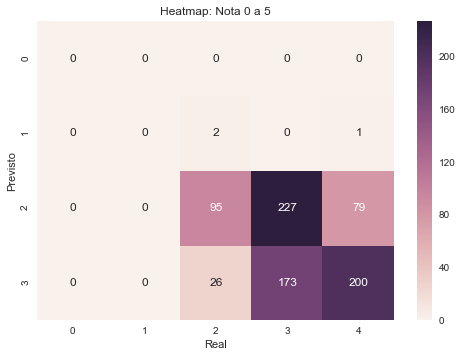

In [244]:
ax = sns.heatmap(Matriz2[1:], annot=True,fmt='d')
plt.title("Heatmap: Nota 0 a 5")
plt.xlabel("Real")
plt.ylabel("Previsto")
plt.show()